In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
df = pd.read_csv('QVI_data.csv')
df = df[~df['PROD_NAME'].str.lower().str.contains('salsa')]
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEAR_MONTH'] = df['DATE'].dt.strftime('%Y%m').astype(int)
df.head()


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEAR_MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246740 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    246740 non-null  int64         
 1   DATE              246740 non-null  datetime64[ns]
 2   STORE_NBR         246740 non-null  int64         
 3   TXN_ID            246740 non-null  int64         
 4   PROD_NBR          246740 non-null  int64         
 5   PROD_NAME         246740 non-null  object        
 6   PROD_QTY          246740 non-null  int64         
 7   TOT_SALES         246740 non-null  float64       
 8   PACK_SIZE         246740 non-null  int64         
 9   BRAND             246740 non-null  object        
 10  LIFESTAGE         246740 non-null  object        
 11  PREMIUM_CUSTOMER  246740 non-null  object        
 12  YEAR_MONTH        246740 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(6), object(4)


In [6]:
measureOverTime = (
    df.groupby(['STORE_NBR', 'YEAR_MONTH'])
    .agg(
        totSales=('TOT_SALES', 'sum'),
        nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
        nTransactions=('TXN_ID', pd.Series.nunique),  # Unique transactions per store/month
        nChips=('PROD_QTY', 'sum'),
        avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / df.loc[x.index, 'PROD_QTY'].sum())
    )
    .reset_index()
)

# Calculate transactions per customer
measureOverTime['nTxnPerCust'] = measureOverTime['nTransactions'] / measureOverTime['nCustomers']
measureOverTime['nChipsPerTxn'] = measureOverTime['nChips'] / measureOverTime['nTransactions']

# Drop extra columns
measureOverTime.drop(columns=['nTransactions', 'nChips'], inplace=True)

# Sort by store and year-month
measureOverTime = measureOverTime.sort_values(by=['STORE_NBR', 'YEAR_MONTH'])

measureOverTime.head()



,STORE_NBR,YEAR_MONTH,totSales,nCustomers,avgPricePerUnit,nTxnPerCust,nChipsPerTxn
0,1,201807,188.9,47,3.256897,1.042553,1.183673
1,1,201808,168.4,41,3.238462,1.000000,1.268293
2,1,201809,268.1,57,3.776056,1.035088,1.203390
3,1,201810,175.4,39,3.439216,1.025641,1.275000
4,1,201811,184.8,44,3.360000,1.022727,1.222222


In [7]:
# Find out which stores have full observation
storesWithFullObs = measureOverTime.groupby('STORE_NBR')['YEAR_MONTH'].nunique()
storesWithFullObs = storesWithFullObs[storesWithFullObs == 12].index.tolist()  # Fix `.to_list()`

# Filter out to only stores with full observation and before 201902
preTrialMeasures = measureOverTime[
    (measureOverTime['YEAR_MONTH'] < 201902) & (measureOverTime['STORE_NBR'].isin(storesWithFullObs))
]

In [8]:
def calculate_correlation(inputTable, metricCol, storeComparison):
    trial_store_data = inputTable[inputTable['STORE_NBR'] == storeComparison].set_index('YEAR_MONTH')[metricCol]
    correlation_results = []
    storeNumbers = inputTable['STORE_NBR'].unique()
    storeNumbers = [s for s in storeNumbers if s != storeComparison]

    for store in storeNumbers:
        control_store_data = inputTable[inputTable['STORE_NBR'] == store].set_index('YEAR_MONTH')[metricCol]

        # Merge data to align month-year entries
        merged_data = pd.merge(trial_store_data, control_store_data, left_index=True, right_index=True, how='inner')

        # Calculate Pearson correlation if there are enough data points
        if len(merged_data) > 1:
            corr_value, _ = stats.pearsonr(merged_data.iloc[:, 0], merged_data.iloc[:, 1])
        else:
            corr_value = None  # Not enough data

        correlation_results.append({'Store1': storeComparison, 'Store2': store, 'corr_measure': corr_value})

    return pd.DataFrame(correlation_results)

In [9]:
def calculate_magnitude_distance(inputTable, metricCol, storeComparison):
    storeNumbers = inputTable['STORE_NBR'].unique()
    storeNumbers = [s for s in storeNumbers if s != storeComparison]
    distance_results = []
    trial_data = inputTable[inputTable['STORE_NBR'] == storeComparison].set_index('YEAR_MONTH')[metricCol]

    for store in storeNumbers:
        control_data = inputTable[inputTable['STORE_NBR'] == store].set_index('YEAR_MONTH')[metricCol]

        # Merge data to align month-year entries
        merged_data = pd.merge(trial_data, control_data, left_index=True, right_index=True, how='inner')

        # Compute absolute difference
        merged_data['measure'] = abs(merged_data.iloc[:, 0] - merged_data.iloc[:, 1])

        # Store results
        for index, row in merged_data.iterrows():
            distance_results.append({
                'Store1': storeComparison,
                'Store2': store,
                'YEAR_MONTH': index,
                'measure': row['measure']
            })

    # Convert list to DataFrame
    distance_df = pd.DataFrame(distance_results)

    # Min-max normalization for each Store1 and YEARMONTH
    min_max_dist = distance_df.groupby(['Store1', 'YEAR_MONTH'])['measure'].agg(['min', 'max']).reset_index()
    distance_df = distance_df.merge(min_max_dist, on=['Store1', 'YEAR_MONTH'])

    # Avoid division by zero
    distance_df['magnitudeMeasure'] = 1 - ((distance_df['measure'] - distance_df['min']) / (distance_df['max'] - distance_df['min']).replace(0, np.nan))

    # Compute the average magnitude measure for each store pair
    final_dist_table = distance_df.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final_dist_table.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)

    return final_dist_table

In [10]:
trial_store = 77  # Define the trial store number

# Calculate correlation for total sales
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)

# Calculate correlation for number of customers
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

# Calculate magnitude distance for total sales
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)

# Calculate magnitude distance for number of customers
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

In [11]:
corr_weight = 0.5 

# Merge correlation and magnitude tables
score_nSales = corr_nSales.merge(magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = corr_weight * score_nSales['corr_measure'] + (1 - corr_weight) * score_nSales['mag_measure']

score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['corr_measure'] + (1 - corr_weight) * score_nCustomers['mag_measure']

# Combine both scores
score_Control = score_nSales.merge(score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']

# Select the best control store (highest score, excluding trial store)
best_control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(
    by='finalControlScore', ascending=False
)

# Exclude trial store itself, select the top-ranked alternative
best_control_store = best_control_store[best_control_store['Store2'] != trial_store].iloc[0]

print(f"Best control store for trial store {trial_store}: {best_control_store['Store2']}")

Best control store for trial store 77: 233.0


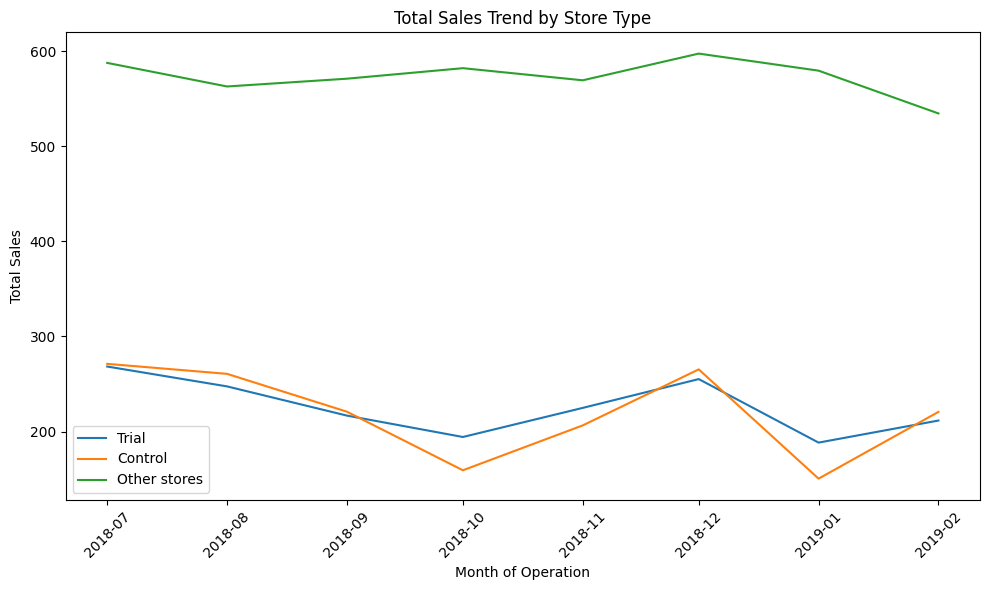

In [ ]:
best_control_store_num = best_control_store['Store2']

# Mark trial, control, and other stores
measureOverTimeSales = measureOverTime.copy()

measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == best_control_store_num else "Other stores")
)

# Calculate average sales for each Store type per month
pastSales = measureOverTimeSales.groupby(['YEAR_MONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Create a 'TransactionMonth' for plotting purposes
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEAR_MONTH'].astype(str), format='%Y%m')

# Filter for data before March 2019
pastSales = pastSales[pastSales['YEAR_MONTH'] < 201903]

# Plotting total sales trend
plt.figure(figsize=(10, 6))
for store_type in ['Trial', 'Control', 'Other stores']:
    store_data = pastSales[pastSales['Store_type'] == store_type]
    plt.plot(store_data['TransactionMonth'], store_data['totSales'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales Trend by Store Type')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

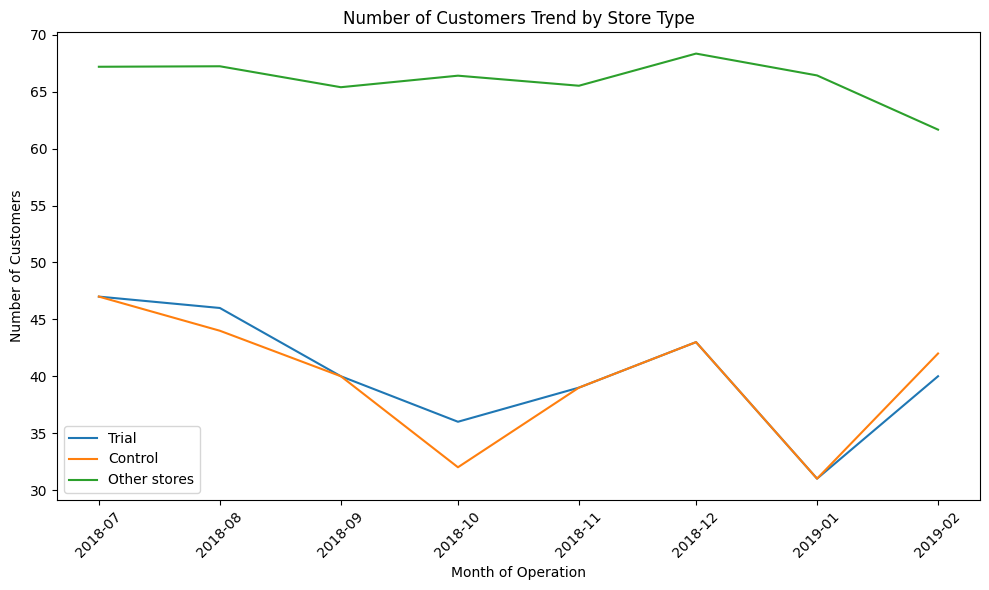

In [13]:
# Mark trial, control, and other stores for number of customers
measureOverTimeCusts = measureOverTime.copy()

measureOverTimeCusts['Store_type'] = measureOverTimeCusts['STORE_NBR'].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == best_control_store_num else "Other stores")
)

# Calculate average customer count for each Store type per month
pastCustomers = measureOverTimeCusts.groupby(['YEAR_MONTH', 'Store_type'], as_index=False)['nCustomers'].mean()

# Create a 'TransactionMonth' for plotting purposes
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEAR_MONTH'].astype(str), format='%Y%m')

# Filter for data before March 2019
pastCustomers = pastCustomers[pastCustomers['YEAR_MONTH'] < 201903]

# Plotting number of customers trend
plt.figure(figsize=(10, 6))
for store_type in ['Trial', 'Control', 'Other stores']:
    store_data = pastCustomers[pastCustomers['Store_type'] == store_type]
    plt.plot(store_data['TransactionMonth'], store_data['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers Trend by Store Type')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Step 1: Filter the data to get sales during the trial period (Feb 2019 - Apr 2019)
trial_sales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & 
                                   (measureOverTimeSales['YEAR_MONTH'] >= 201902) & 
                                   (measureOverTimeSales['YEAR_MONTH'] <= 201904)]

# Step 2: Apply the scaling factor to the control store's sales to match the trial store
scaling_factor_for_control_sales = preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == trial_store) & 
                                                        (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum() / \
                                   preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == best_control_store_num) & 
                                                         (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum()

scaled_control_sales = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == best_control_store_num].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales

# Step 3: Merge the trial store sales and scaled control store sales data
# Rename 'totSales' in trial_sales to 'totSales_trial' for clarity
trial_sales = trial_sales.rename(columns={'totSales': 'totSales_trial'})

# Merge data based on 'YEARMONTH'
comparison_data = pd.merge(trial_sales, scaled_control_sales[['YEAR_MONTH', 'controlSales']], on='YEAR_MONTH', suffixes=('_trial', '_control'))

# Step 4: Calculate the percentage difference between the trial sales and the scaled control sales
comparison_data['percentageDiff'] = ((comparison_data['controlSales'] - comparison_data['totSales_trial']) / comparison_data['totSales_trial']) * 100

# Display the result
print(comparison_data[['YEAR_MONTH', 'totSales_trial', 'controlSales', 'percentageDiff']])

   YEAR_MONTH  totSales_trial  controlSales  percentageDiff
0      201902           211.6    229.473346        8.446761
1      201903           255.1    187.779277      -26.389935
2      201904           258.1    149.932291      -41.909225


In [16]:
# Step 1: Filter the sales data for the trial period (Feb 2019 - Apr 2019) and pre-trial period
trial_sales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & 
                                   (measureOverTimeSales['YEAR_MONTH'] >= 201902) & 
                                   (measureOverTimeSales['YEAR_MONTH'] <= 201904)]

# Pre-trial sales for both trial and control stores (before Feb 2019)
pre_trial_sales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & 
                                       (measureOverTimeSales['YEAR_MONTH'] < 201902)]

# Step 2: Apply the scaling factor to the control store's sales to match the trial store
scaling_factor_for_control_sales = preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == trial_store) & 
                                                        (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum() / \
                                   preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == best_control_store_num) & 
                                                         (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum()

scaled_control_sales = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == best_control_store_num].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales

# Step 3: Calculate percentageDiff for the pre-trial period
pre_trial_sales['controlSales'] = pre_trial_sales['totSales'] * scaling_factor_for_control_sales
pre_trial_sales['percentageDiff'] = ((pre_trial_sales['controlSales'] - pre_trial_sales['totSales']) / pre_trial_sales['totSales']) * 100

# Step 4: Merge trial and pre-trial sales data
trial_sales = trial_sales.rename(columns={'totSales': 'totSales_trial'})
comparison_data = pd.merge(trial_sales, scaled_control_sales[['YEAR_MONTH', 'controlSales']], on='YEAR_MONTH', suffixes=('_trial', '_control'))

# Step 5: Calculate percentageDiff for the trial period
comparison_data['percentageDiff'] = ((comparison_data['controlSales'] - comparison_data['totSales_trial']) / comparison_data['totSales_trial']) * 100

# Step 6: Calculate the standard deviation for the pre-trial period
std_dev = pre_trial_sales['percentageDiff'].std()
print(f"Standard Deviation: {std_dev}")

# Step 7: Calculate the t-value for each trial month (null hypothesis mean = 0)
comparison_data['tValue'] = (comparison_data['percentageDiff'] - 0) / std_dev

# Step 8: Calculate the critical t-value for 95% confidence with 7 degrees of freedom (two-tailed test)
from scipy import stats
critical_t_value = stats.t.ppf(0.975, df=7)  # 0.975 for 95% confidence in a two-tailed test

# Step 9: Check for statistical significance
comparison_data['statisticallySignificant'] = comparison_data['tValue'].abs() > critical_t_value

# Step 10: Display the results
print(comparison_data)

Standard Deviation: 5.698664223447309e-15
   STORE_NBR  YEAR_MONTH  totSales_trial  nCustomers  avgPricePerUnit  \
0         77      201902           211.6          40         3.158209   
1         77      201903           255.1          46         3.356579   
2         77      201904           258.1          47         3.396053   

   nTxnPerCust  nChipsPerTxn Store_type  controlSales  percentageDiff  \
0     1.000000      1.675000      Trial    229.473346        8.446761   
1     1.108696      1.490196      Trial    187.779277      -26.389935   
2     1.000000      1.617021      Trial    149.932291      -41.909225   

         tValue  statisticallySignificant  
0  1.482235e+15                      True  
1 -4.630898e+15                      True  
2 -7.354219e+15                      True  


C:\Users\Bran\AppData\Local\Temp\ipykernel_41828\1463946513.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_trial_sales['controlSales'] = pre_trial_sales['totSales'] * scaling_factor_for_control_sales
C:\Users\Bran\AppData\Local\Temp\ipykernel_41828\1463946513.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_trial_sales['percentageDiff'] = ((pre_trial_sales['controlSales'] - pre_trial_sales['totSales']) / pre_trial_sales['totSales']) * 100


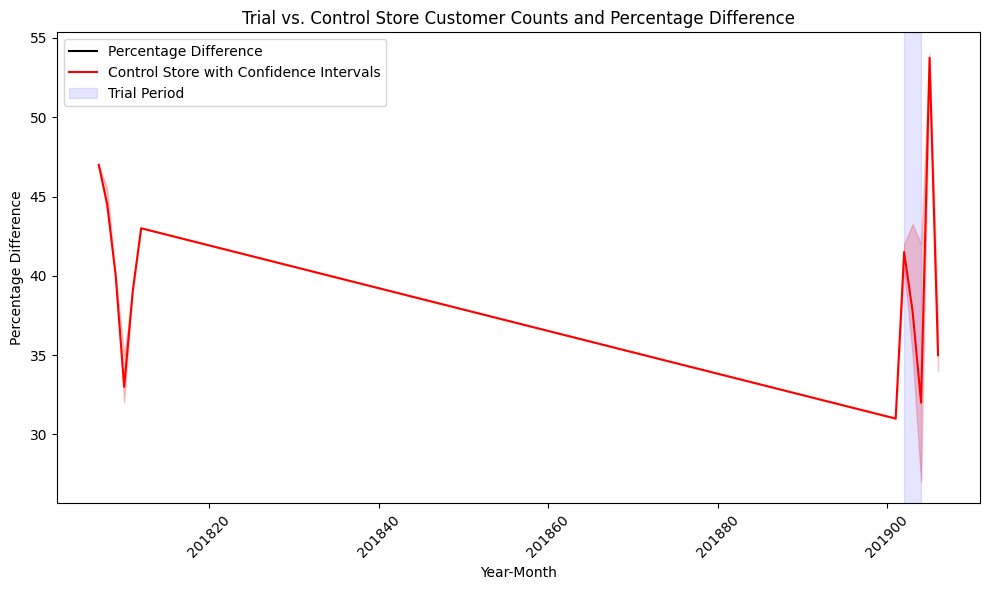

In [ ]:
# Filter for trial store and pre-trial period (Feb 2019 - Apr 2019)
trial_store_custs = measureOverTimeCusts[(measureOverTimeCusts['STORE_NBR'] == trial_store) & 
                                          (measureOverTimeCusts['YEAR_MONTH'] >= 201902) & 
                                          (measureOverTimeCusts['YEAR_MONTH'] <= 201904)]

# Filter for control store and pre-trial period (before Feb 2019)
control_store_custs = measureOverTimeCusts[(measureOverTimeCusts['STORE_NBR'] == best_control_store_num) & 
                                            (measureOverTimeCusts['YEAR_MONTH'] < 201902)]

# Step 2: Compute the scaling factor based on pre-trial customers
scaling_factor_for_control_custs = control_store_custs['nCustomers'].sum() / trial_store_custs['nCustomers'].sum()

# Apply the scaling factor to control store customers
scaled_control_customers = control_store_custs.copy()
scaled_control_customers['nCustomers'] = scaled_control_customers['nCustomers'] * scaling_factor_for_control_custs

# Step 3: Merge trial store customers and scaled control store customers based on YEAR_MONTH
comparison_custs = pd.merge(trial_store_custs, scaled_control_customers[['YEAR_MONTH', 'nCustomers']], 
                            on='YEAR_MONTH', suffixes=('_trial', '_control'))

# Step 4: Calculate the percentage difference between trial and scaled control store customers
comparison_custs['percentageDiff'] = ((comparison_custs['nCustomers_control'] - comparison_custs['nCustomers_trial']) / 
                                      comparison_custs['nCustomers_trial']) * 100

# Step 5: Calculate the standard deviation from the pre-trial period
std_dev_custs = comparison_custs[comparison_custs['YEAR_MONTH'] < 201902]['percentageDiff'].std()

# Degrees of freedom (for t-test)
degrees_of_freedom = 7

# Calculate the critical t-value for 95% confidence (two-tailed test)
critical_t_value = stats.t.ppf(0.975, df=degrees_of_freedom)

# Calculate the 95th percentile confidence intervals for control store customers
past_customers = measureOverTimeCusts.groupby(['YEAR_MONTH', 'Store_type'])['nCustomers'].mean().reset_index()
past_customers = past_customers[past_customers['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
past_customers_controls_95 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_controls_95['nCustomers'] = past_customers_controls_95['nCustomers'] * (1 + std_dev_custs * 2)
past_customers_controls_95['Store_type'] = "Control 95th % confidence interval"

# Control store 5th percentile
past_customers_controls_5 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_controls_5['nCustomers'] = past_customers_controls_5['nCustomers'] * (1 - std_dev_custs * 2)
past_customers_controls_5['Store_type'] = "Control 5th % confidence interval"

# Combine all data for plotting
trial_assessment = pd.concat([past_customers, past_customers_controls_95, past_customers_controls_5])

# Step 6: Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_custs, x='YEAR_MONTH', y='percentageDiff', label='Percentage Difference', color='black')
sns.lineplot(data=trial_assessment, x='YEAR_MONTH', y='nCustomers', label='Control Store with Confidence Intervals', color='red')

# Add shaded region for trial period
plt.axvspan(201902, 201904, color='blue', alpha=0.1, label='Trial Period')

plt.title('Trial vs. Control Store Customer Counts and Percentage Difference')
plt.xlabel('Year-Month')
plt.ylabel('Percentage Difference')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [18]:
#Repeat with different store
trial_store = 86
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

corr_weight = 0.5 
score_nSales = corr_nSales.merge(magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = corr_weight * score_nSales['corr_measure'] + (1 - corr_weight) * score_nSales['mag_measure']
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['corr_measure'] + (1 - corr_weight) * score_nCustomers['mag_measure']
score_Control = score_nSales.merge(score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']
best_control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(
    by='finalControlScore', ascending=False
)
best_control_store = best_control_store[best_control_store['Store2'] != trial_store].iloc[0]
print(f"Best control store for trial store {trial_store}: {best_control_store['Store2']}")

Best control store for trial store 86: 155.0


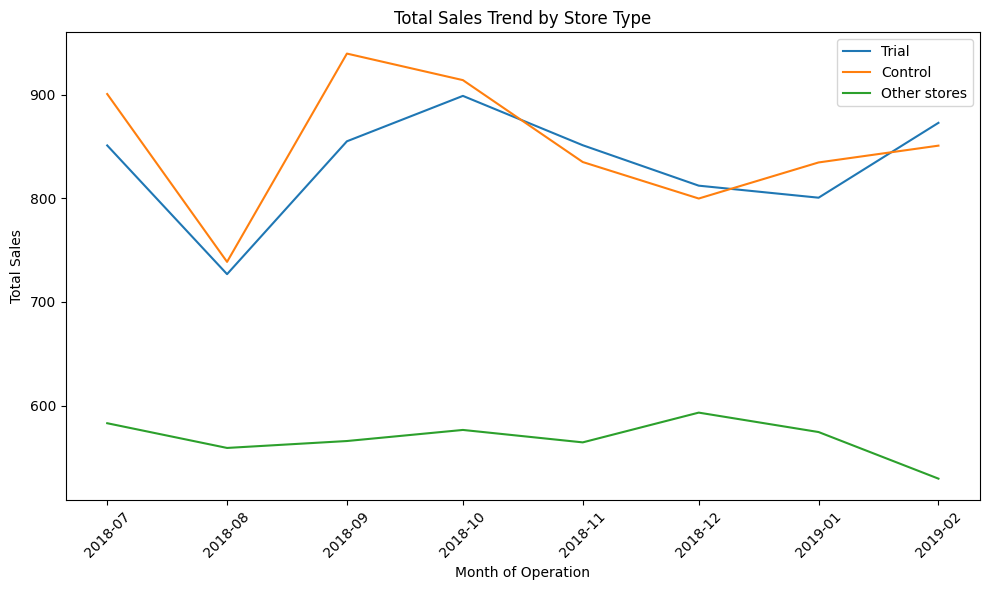

In [ ]:
best_control_store_num = best_control_store['Store2']
measureOverTimeSales = measureOverTime.copy()
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == best_control_store_num else "Other stores")
)
pastSales = measureOverTimeSales.groupby(['YEAR_MONTH', 'Store_type'], as_index=False)['totSales'].mean()
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEAR_MONTH'].astype(str), format='%Y%m')
pastSales = pastSales[pastSales['YEAR_MONTH'] < 201903]
plt.figure(figsize=(10, 6))
for store_type in ['Trial', 'Control', 'Other stores']:
    store_data = pastSales[pastSales['Store_type'] == store_type]
    plt.plot(store_data['TransactionMonth'], store_data['totSales'], label=store_type)
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales Trend by Store Type')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

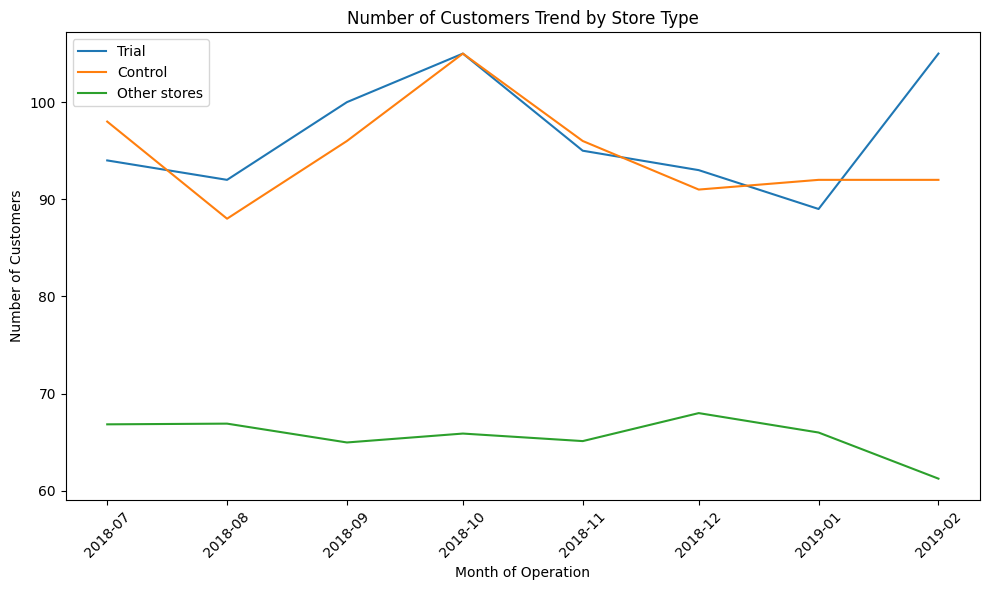

In [20]:
measureOverTimeCusts = measureOverTime.copy()
measureOverTimeCusts['Store_type'] = measureOverTimeCusts['STORE_NBR'].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == best_control_store_num else "Other stores")
)
pastCustomers = measureOverTimeCusts.groupby(['YEAR_MONTH', 'Store_type'], as_index=False)['nCustomers'].mean()
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEAR_MONTH'].astype(str), format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['YEAR_MONTH'] < 201903]
plt.figure(figsize=(10, 6))
for store_type in ['Trial', 'Control', 'Other stores']:
    store_data = pastCustomers[pastCustomers['Store_type'] == store_type]
    plt.plot(store_data['TransactionMonth'], store_data['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers Trend by Store Type')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
trial_sales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & 
                                   (measureOverTimeSales['YEAR_MONTH'] >= 201902) & 
                                   (measureOverTimeSales['YEAR_MONTH'] <= 201904)]
scaling_factor_for_control_sales = preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == trial_store) & 
                                                        (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum() / \
                                   preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == best_control_store_num) & 
                                                         (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum()
scaled_control_sales = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == best_control_store_num].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales
trial_sales = trial_sales.rename(columns={'totSales': 'totSales_trial'})
comparison_data = pd.merge(trial_sales, scaled_control_sales[['YEAR_MONTH', 'controlSales']], on='YEAR_MONTH', suffixes=('_trial', '_control'))
comparison_data['percentageDiff'] = ((comparison_data['controlSales'] - comparison_data['totSales_trial']) / comparison_data['totSales_trial']) * 100
print(comparison_data[['YEAR_MONTH', 'totSales_trial', 'controlSales', 'percentageDiff']])

   YEAR_MONTH  totSales_trial  controlSales  percentageDiff
0      201902           872.8    827.019610       -5.245233
1      201903           945.4    745.561872      -21.137945
2      201904           804.0    778.028321       -3.230308


In [22]:
trial_sales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & 
                                   (measureOverTimeSales['YEAR_MONTH'] >= 201902) & 
                                   (measureOverTimeSales['YEAR_MONTH'] <= 201904)]
pre_trial_sales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & 
                                       (measureOverTimeSales['YEAR_MONTH'] < 201902)]
scaling_factor_for_control_sales = preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == trial_store) & 
                                                        (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum() / \
                                   preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == best_control_store_num) & 
                                                         (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum()
scaled_control_sales = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == best_control_store_num].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales
pre_trial_sales['controlSales'] = pre_trial_sales['totSales'] * scaling_factor_for_control_sales
pre_trial_sales['percentageDiff'] = ((pre_trial_sales['controlSales'] - pre_trial_sales['totSales']) / pre_trial_sales['totSales']) * 100
trial_sales = trial_sales.rename(columns={'totSales': 'totSales_trial'})
comparison_data = pd.merge(trial_sales, scaled_control_sales[['YEAR_MONTH', 'controlSales']], on='YEAR_MONTH', suffixes=('_trial', '_control'))
comparison_data['percentageDiff'] = ((comparison_data['controlSales'] - comparison_data['totSales_trial']) / comparison_data['totSales_trial']) * 100
std_dev = pre_trial_sales['percentageDiff'].std()
print(f"Standard Deviation: {std_dev}")
comparison_data['tValue'] = (comparison_data['percentageDiff'] - 0) / std_dev
from scipy import stats
critical_t_value = stats.t.ppf(0.975, df=7)  
comparison_data['statisticallySignificant'] = comparison_data['tValue'].abs() > critical_t_value
print(comparison_data)

Standard Deviation: 1.6114177442092715e-15
   STORE_NBR  YEAR_MONTH  totSales_trial  nCustomers  avgPricePerUnit  \
0         86      201902           872.8         105         3.344061   
1         86      201903           945.4         108         3.692969   
2         86      201904           804.0          99         3.350000   

   nTxnPerCust  nChipsPerTxn Store_type  controlSales  percentageDiff  \
0     1.238095      2.007692      Trial    827.019610       -5.245233   
1     1.175926      2.015748      Trial    745.561872      -21.137945   
2     1.202020      2.016807      Trial    778.028321       -3.230308   

         tValue  statisticallySignificant  
0 -3.255042e+15                      True  
1 -1.311761e+16                      True  
2 -2.004637e+15                      True  


C:\Users\Bran\AppData\Local\Temp\ipykernel_41828\2355260800.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_trial_sales['controlSales'] = pre_trial_sales['totSales'] * scaling_factor_for_control_sales
C:\Users\Bran\AppData\Local\Temp\ipykernel_41828\2355260800.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_trial_sales['percentageDiff'] = ((pre_trial_sales['controlSales'] - pre_trial_sales['totSales']) / pre_trial_sales['totSales']) * 100


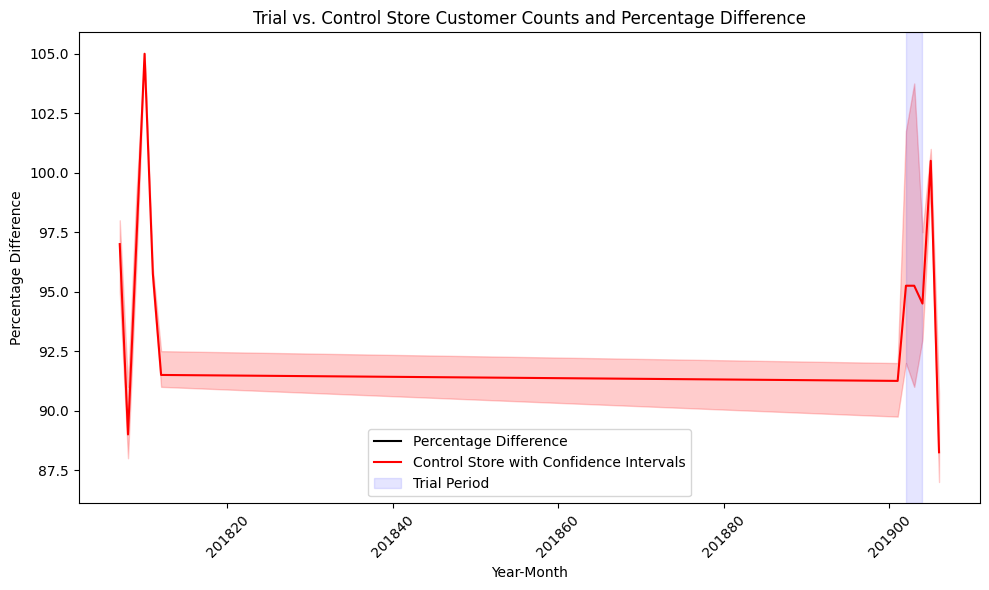

In [23]:
trial_store_custs = measureOverTimeCusts[(measureOverTimeCusts['STORE_NBR'] == trial_store) & 
                                          (measureOverTimeCusts['YEAR_MONTH'] >= 201902) & 
                                          (measureOverTimeCusts['YEAR_MONTH'] <= 201904)]
control_store_custs = measureOverTimeCusts[(measureOverTimeCusts['STORE_NBR'] == best_control_store_num) & 
                                            (measureOverTimeCusts['YEAR_MONTH'] < 201902)]
scaling_factor_for_control_custs = control_store_custs['nCustomers'].sum() / trial_store_custs['nCustomers'].sum()
scaled_control_customers = control_store_custs.copy()
scaled_control_customers['nCustomers'] = scaled_control_customers['nCustomers'] * scaling_factor_for_control_custs
comparison_custs = pd.merge(trial_store_custs, scaled_control_customers[['YEAR_MONTH', 'nCustomers']], 
                            on='YEAR_MONTH', suffixes=('_trial', '_control'))
comparison_custs['percentageDiff'] = ((comparison_custs['nCustomers_control'] - comparison_custs['nCustomers_trial']) / 
                                      comparison_custs['nCustomers_trial']) * 100
std_dev_custs = comparison_custs[comparison_custs['YEAR_MONTH'] < 201902]['percentageDiff'].std()
degrees_of_freedom = 7
critical_t_value = stats.t.ppf(0.975, df=degrees_of_freedom)
past_customers = measureOverTimeCusts.groupby(['YEAR_MONTH', 'Store_type'])['nCustomers'].mean().reset_index()
past_customers = past_customers[past_customers['Store_type'].isin(['Trial', 'Control'])]
past_customers_controls_95 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_controls_95['nCustomers'] = past_customers_controls_95['nCustomers'] * (1 + std_dev_custs * 2)
past_customers_controls_95['Store_type'] = "Control 95th % confidence interval"
past_customers_controls_5 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_controls_5['nCustomers'] = past_customers_controls_5['nCustomers'] * (1 - std_dev_custs * 2)
past_customers_controls_5['Store_type'] = "Control 5th % confidence interval"
trial_assessment = pd.concat([past_customers, past_customers_controls_95, past_customers_controls_5])
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_custs, x='YEAR_MONTH', y='percentageDiff', label='Percentage Difference', color='black')
sns.lineplot(data=trial_assessment, x='YEAR_MONTH', y='nCustomers', label='Control Store with Confidence Intervals', color='red')
plt.axvspan(201902, 201904, color='blue', alpha=0.1, label='Trial Period')
plt.title('Trial vs. Control Store Customer Counts and Percentage Difference')
plt.xlabel('Year-Month')
plt.ylabel('Percentage Difference')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
#Repeat with different store
trial_store = 88
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

corr_weight = 0.5 
score_nSales = corr_nSales.merge(magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = corr_weight * score_nSales['corr_measure'] + (1 - corr_weight) * score_nSales['mag_measure']
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['corr_measure'] + (1 - corr_weight) * score_nCustomers['mag_measure']
score_Control = score_nSales.merge(score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']
best_control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(
    by='finalControlScore', ascending=False
)
best_control_store = best_control_store[best_control_store['Store2'] != trial_store].iloc[0]
print(f"Best control store for trial store {trial_store}: {best_control_store['Store2']}")

Best control store for trial store 88: 237.0


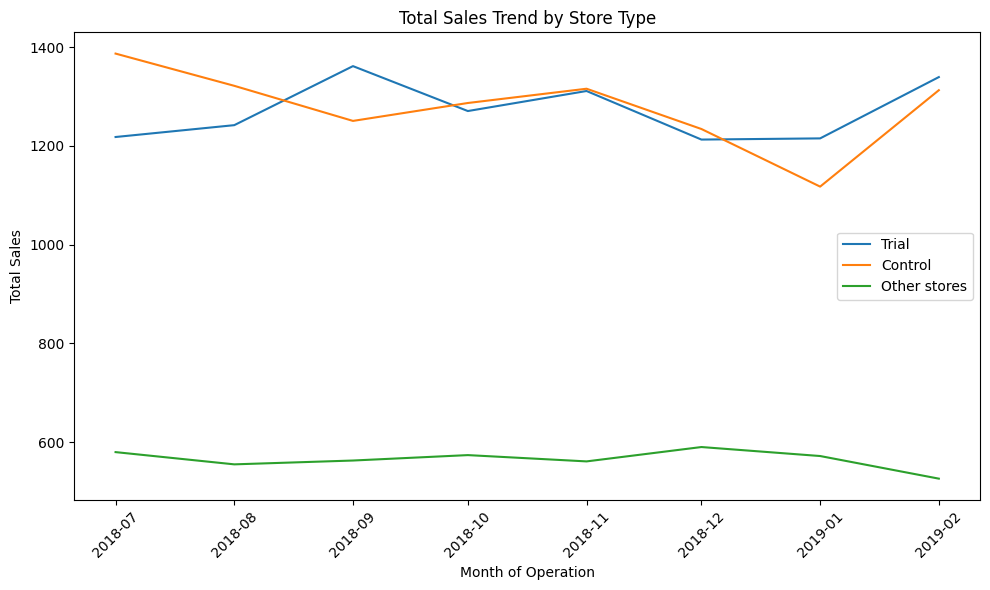

In [25]:
best_control_store_num = best_control_store['Store2']
measureOverTimeSales = measureOverTime.copy()
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == best_control_store_num else "Other stores")
)
pastSales = measureOverTimeSales.groupby(['YEAR_MONTH', 'Store_type'], as_index=False)['totSales'].mean()
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEAR_MONTH'].astype(str), format='%Y%m')
pastSales = pastSales[pastSales['YEAR_MONTH'] < 201903]
plt.figure(figsize=(10, 6))
for store_type in ['Trial', 'Control', 'Other stores']:
    store_data = pastSales[pastSales['Store_type'] == store_type]
    plt.plot(store_data['TransactionMonth'], store_data['totSales'], label=store_type)
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales Trend by Store Type')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

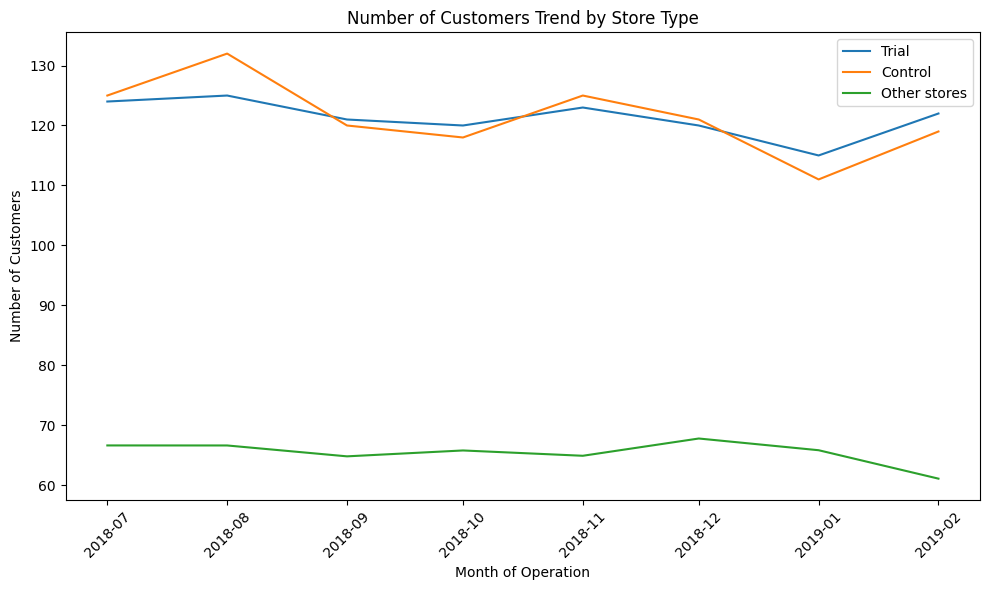

In [26]:
measureOverTimeCusts = measureOverTime.copy()
measureOverTimeCusts['Store_type'] = measureOverTimeCusts['STORE_NBR'].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == best_control_store_num else "Other stores")
)
pastCustomers = measureOverTimeCusts.groupby(['YEAR_MONTH', 'Store_type'], as_index=False)['nCustomers'].mean()
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEAR_MONTH'].astype(str), format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['YEAR_MONTH'] < 201903]
plt.figure(figsize=(10, 6))
for store_type in ['Trial', 'Control', 'Other stores']:
    store_data = pastCustomers[pastCustomers['Store_type'] == store_type]
    plt.plot(store_data['TransactionMonth'], store_data['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers Trend by Store Type')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
trial_sales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & 
                                   (measureOverTimeSales['YEAR_MONTH'] >= 201902) & 
                                   (measureOverTimeSales['YEAR_MONTH'] <= 201904)]
scaling_factor_for_control_sales = preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == trial_store) & 
                                                        (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum() / \
                                   preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == best_control_store_num) & 
                                                         (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum()
scaled_control_sales = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == best_control_store_num].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales
trial_sales = trial_sales.rename(columns={'totSales': 'totSales_trial'})
comparison_data = pd.merge(trial_sales, scaled_control_sales[['YEAR_MONTH', 'controlSales']], on='YEAR_MONTH', suffixes=('_trial', '_control'))
comparison_data['percentageDiff'] = ((comparison_data['controlSales'] - comparison_data['totSales_trial']) / comparison_data['totSales_trial']) * 100
print(comparison_data[['YEAR_MONTH', 'totSales_trial', 'controlSales', 'percentageDiff']])

   YEAR_MONTH  totSales_trial  controlSales  percentageDiff
0      201902          1339.6   1300.879003       -2.890489
1      201903          1467.0   1166.728952      -20.468374
2      201904          1317.0   1142.950509      -13.215603


In [28]:
trial_sales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & 
                                   (measureOverTimeSales['YEAR_MONTH'] >= 201902) & 
                                   (measureOverTimeSales['YEAR_MONTH'] <= 201904)]
pre_trial_sales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == trial_store) & 
                                       (measureOverTimeSales['YEAR_MONTH'] < 201902)]
scaling_factor_for_control_sales = preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == trial_store) & 
                                                        (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum() / \
                                   preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == best_control_store_num) & 
                                                         (preTrialMeasures['YEAR_MONTH'] < 201902), 'totSales'].sum()
scaled_control_sales = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == best_control_store_num].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales
pre_trial_sales['controlSales'] = pre_trial_sales['totSales'] * scaling_factor_for_control_sales
pre_trial_sales['percentageDiff'] = ((pre_trial_sales['controlSales'] - pre_trial_sales['totSales']) / pre_trial_sales['totSales']) * 100
trial_sales = trial_sales.rename(columns={'totSales': 'totSales_trial'})
comparison_data = pd.merge(trial_sales, scaled_control_sales[['YEAR_MONTH', 'controlSales']], on='YEAR_MONTH', suffixes=('_trial', '_control'))
comparison_data['percentageDiff'] = ((comparison_data['controlSales'] - comparison_data['totSales_trial']) / comparison_data['totSales_trial']) * 100
std_dev = pre_trial_sales['percentageDiff'].std()
print(f"Standard Deviation: {std_dev}")
comparison_data['tValue'] = (comparison_data['percentageDiff'] - 0) / std_dev
from scipy import stats
critical_t_value = stats.t.ppf(0.975, df=7)  
comparison_data['statisticallySignificant'] = comparison_data['tValue'].abs() > critical_t_value
print(comparison_data)

Standard Deviation: 5.460634702330805e-15
   STORE_NBR  YEAR_MONTH  totSales_trial  nCustomers  avgPricePerUnit  \
0         88      201902          1339.6         122         4.435762   
1         88      201903          1467.0         133         4.340237   
2         88      201904          1317.0         119         4.390000   

   nTxnPerCust  nChipsPerTxn Store_type  controlSales  percentageDiff  \
0     1.229508      2.013333      Trial   1300.879003       -2.890489   
1     1.263158      2.011905      Trial   1166.728952      -20.468374   
2     1.260504      2.000000      Trial   1142.950509      -13.215603   

         tValue  statisticallySignificant  
0 -5.293321e+14                      True  
1 -3.748351e+15                      True  
2 -2.420159e+15                      True  


C:\Users\Bran\AppData\Local\Temp\ipykernel_41828\2355260800.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_trial_sales['controlSales'] = pre_trial_sales['totSales'] * scaling_factor_for_control_sales
C:\Users\Bran\AppData\Local\Temp\ipykernel_41828\2355260800.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_trial_sales['percentageDiff'] = ((pre_trial_sales['controlSales'] - pre_trial_sales['totSales']) / pre_trial_sales['totSales']) * 100


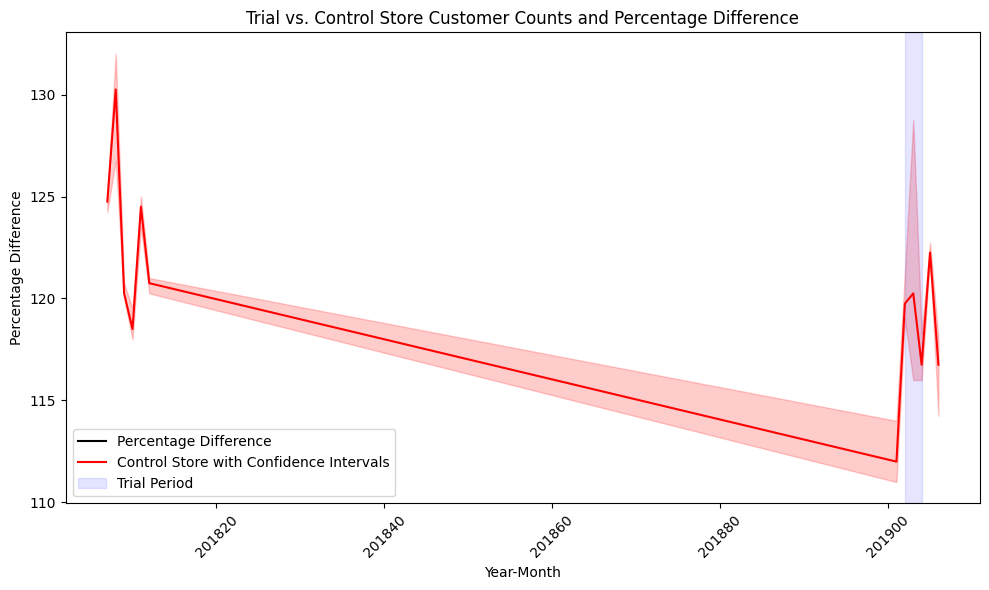

In [29]:
trial_store_custs = measureOverTimeCusts[(measureOverTimeCusts['STORE_NBR'] == trial_store) & 
                                          (measureOverTimeCusts['YEAR_MONTH'] >= 201902) & 
                                          (measureOverTimeCusts['YEAR_MONTH'] <= 201904)]
control_store_custs = measureOverTimeCusts[(measureOverTimeCusts['STORE_NBR'] == best_control_store_num) & 
                                            (measureOverTimeCusts['YEAR_MONTH'] < 201902)]
scaling_factor_for_control_custs = control_store_custs['nCustomers'].sum() / trial_store_custs['nCustomers'].sum()
scaled_control_customers = control_store_custs.copy()
scaled_control_customers['nCustomers'] = scaled_control_customers['nCustomers'] * scaling_factor_for_control_custs
comparison_custs = pd.merge(trial_store_custs, scaled_control_customers[['YEAR_MONTH', 'nCustomers']], 
                            on='YEAR_MONTH', suffixes=('_trial', '_control'))
comparison_custs['percentageDiff'] = ((comparison_custs['nCustomers_control'] - comparison_custs['nCustomers_trial']) / 
                                      comparison_custs['nCustomers_trial']) * 100
std_dev_custs = comparison_custs[comparison_custs['YEAR_MONTH'] < 201902]['percentageDiff'].std()
degrees_of_freedom = 7
critical_t_value = stats.t.ppf(0.975, df=degrees_of_freedom)
past_customers = measureOverTimeCusts.groupby(['YEAR_MONTH', 'Store_type'])['nCustomers'].mean().reset_index()
past_customers = past_customers[past_customers['Store_type'].isin(['Trial', 'Control'])]
past_customers_controls_95 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_controls_95['nCustomers'] = past_customers_controls_95['nCustomers'] * (1 + std_dev_custs * 2)
past_customers_controls_95['Store_type'] = "Control 95th % confidence interval"
past_customers_controls_5 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_controls_5['nCustomers'] = past_customers_controls_5['nCustomers'] * (1 - std_dev_custs * 2)
past_customers_controls_5['Store_type'] = "Control 5th % confidence interval"
trial_assessment = pd.concat([past_customers, past_customers_controls_95, past_customers_controls_5])
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_custs, x='YEAR_MONTH', y='percentageDiff', label='Percentage Difference', color='black')
sns.lineplot(data=trial_assessment, x='YEAR_MONTH', y='nCustomers', label='Control Store with Confidence Intervals', color='red')
plt.axvspan(201902, 201904, color='blue', alpha=0.1, label='Trial Period')
plt.title('Trial vs. Control Store Customer Counts and Percentage Difference')
plt.xlabel('Year-Month')
plt.ylabel('Percentage Difference')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()